In [1]:
import os
import numpy as np

from refl1d.names import *
from bumps.fitters import fit

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

In [2]:
# Data directories
steady_state_data_dir = os.path.expanduser('~/Downloads')
kinetics_dir = os.path.expanduser('~/Downloads/kinetics')
output_dir = '../data'

# This is where the code is
src_dir = os.path.join(os.path.expanduser('~'), 'git', 'time-resolved-nr', 'src')
sys.path.append(src_dir)

# Load the data
This should be the same data as for training

In [3]:
t = 0
delta_t = 10 # seconds
timestamps = []
data_list = []

file_list = sorted(os.listdir(kinetics_dir))[:400]
for i in range(0, len(file_list), 5):
    f = file_list[i]
    if True: #t%100 == 0:
        skiprows = 24 if f.endswith('.mft') else 0
        _file = os.path.join(kinetics_dir, f)
        data = np.loadtxt(_file, skiprows=skiprows).T
        data[2] = data[2]*3.0

        data_list.append(data)
        timestamps.append(t)

    t += 10

print(len(data_list))
print("Final time: %g" % t)



80
Final time: 800


# Set up the environment

In [4]:
import rl_model
from stable_baselines3 import PPO, SAC
from stable_baselines3.common.callbacks import CheckpointCallback


initial_state_expt_file = None #os.path.join(output_dir, 'initial_state-expt.json')
final_state_expt_file = os.path.join(output_dir, 'final_state-expt.json')

# If REVERSE is true, we will use the final state as the base model
REVERSE = True
  
# create an instance of our custom environment
env = rl_model.SLDEnv(initial_state_file=initial_state_expt_file,
                      final_state_file=final_state_expt_file,
                      data=data_list, reverse=REVERSE,
                      use_steady_states=False)

# use the Gymnasium 'check_env' function to check the environment
# - returns nothing if the environment is verified as ok
from gymnasium.utils.env_checker import check_env
check_env(env)

# initialize the environment
env.reset()
env.render()


0


/Users/m2d/miniconda3/envs/playground/lib/python3.8/site-packages/gymnasium/utils/env_checker.py:317: UserWarning: WARN: Not able to test alternative render modes due to the environment not having a spec. Try instantialising the environment through gymnasium.make
  logger.warn(


# Plot the reward as a function of iteration to monitor training

The approach maximizes the reward, so it should increase.

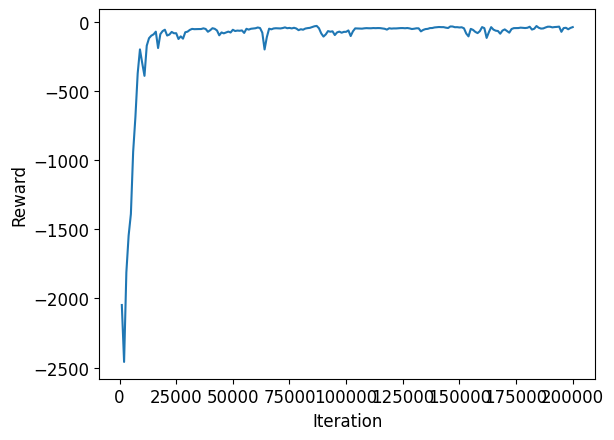

In [48]:
log_dir = "./logs-bck-1/"

_dir_list = os.listdir(log_dir)

def evaluate(model):
    episode_reward = 0
    n_times = len(env.data)
    obs, info = env.reset()

    chi2 = 0
    time_chi2 = []
    
    for i in range(n_times):
        action, _ = model.predict(obs, deterministic=True)
        chi2 += env.chi2
        obs, reward, terminated, truncated, info = env.step(action)  
        episode_reward += reward
        time_chi2.append(reward)

    return episode_reward, time_chi2

itr_list = []
reward_list = []
time_chi2_list = []
models = []

for file in _dir_list:
    try:
        model = SAC.load(os.path.join(log_dir, file))
        reward, time_chi2 = evaluate(model)
        iteration = int(file.replace("rl_model-backward_", "").replace("_steps.zip", ""))
        itr_list.append(iteration)
        reward_list.append(reward)
        time_chi2_list.append(time_chi2)
        models.append(model)
    except:
        print("skip: %s" % file)

time_chi2_list = np.asarray(time_chi2_list)
itr_list = np.asarray(itr_list)
reward_list = np.asarray(reward_list)
idx = itr_list.argsort()

fig = plt.figure(dpi=100)
plt.plot(itr_list[idx], reward_list[idx])
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.show()

In [49]:
model = models[idx[-1]]
episode_reward = 0

n_times = len(env.data)
print("Number of times: %s" % n_times)

obs, info = env.reset()

times = []
actions = []
chi2 = []
for i in range(n_times):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    times.append(timestamps[env.time_stamp])
    _time = timestamps[env.time_stamp]
    new_obs, reward, terminated, truncated, info = env.step(action)  
    chi2.append(env.chi2)
    episode_reward += reward
    print("Time %s %s: %g [%s] %g" % (_time, obs, reward, terminated, episode_reward))
    obs = new_obs


actions = np.asarray(actions)
chi2 = np.asarray(chi2)
times = np.asarray(times)
print(times)

Number of times: 80
Time 790 [1.]: -0.516895 [False] -0.516895
Time 780 [0.98734176]: -0.420312 [False] -0.937207
Time 770 [0.9746835]: -0.444141 [False] -1.38135
Time 760 [0.96202534]: -0.298358 [False] -1.67971
Time 750 [0.9493671]: -0.351163 [False] -2.03087
Time 740 [0.93670887]: -0.213247 [False] -2.24412
Time 730 [0.9240506]: -0.241641 [False] -2.48576
Time 720 [0.9113924]: -0.281601 [False] -2.76736
Time 710 [0.89873415]: -0.248787 [False] -3.01615
Time 700 [0.886076]: -0.244774 [False] -3.26092
Time 690 [0.87341774]: -0.245777 [False] -3.5067
Time 680 [0.8607595]: -0.244114 [False] -3.75081
Time 670 [0.84810126]: -0.226648 [False] -3.97746
Time 660 [0.835443]: -0.168771 [False] -4.14623
Time 650 [0.8227848]: -0.215731 [False] -4.36196
Time 640 [0.8101266]: -0.245295 [False] -4.60725
Time 630 [0.79746836]: -0.155898 [False] -4.76315
Time 620 [0.7848101]: -0.211321 [False] -4.97447
Time 610 [0.7721519]: -0.174934 [False] -5.14941
Time 600 [0.75949365]: -0.27283 [False] -5.42224
T

In [50]:
# There's likely a way to dig into the SAC parameters and fish out the action standard deviations

deltas = env.high_array - env.low_array

samples = []

for n in range(100):
    actions = []
    obs, info = env.reset()
    for i in range(len(env.data)):
        action, _ = model.predict(obs, deterministic=False)
        obs, reward, terminated, truncated, info = env.step(action)
        actions.append(action)
    
    actions = np.asarray(actions)
    values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0
    samples.append(values)


samples = np.asarray(samples).T
print(samples.shape)

errs = np.std(samples, axis=2)
print(errs.shape)

(9, 80, 100)
(9, 80)


['enrich thickness', 'enrich interface', 'enrich rho', 'poly thickness', 'poly interface', 'poly rho', 'surface thickness', 'surface interface', 'surface rho']


Text(0.5, 0, 'time [seconds]')

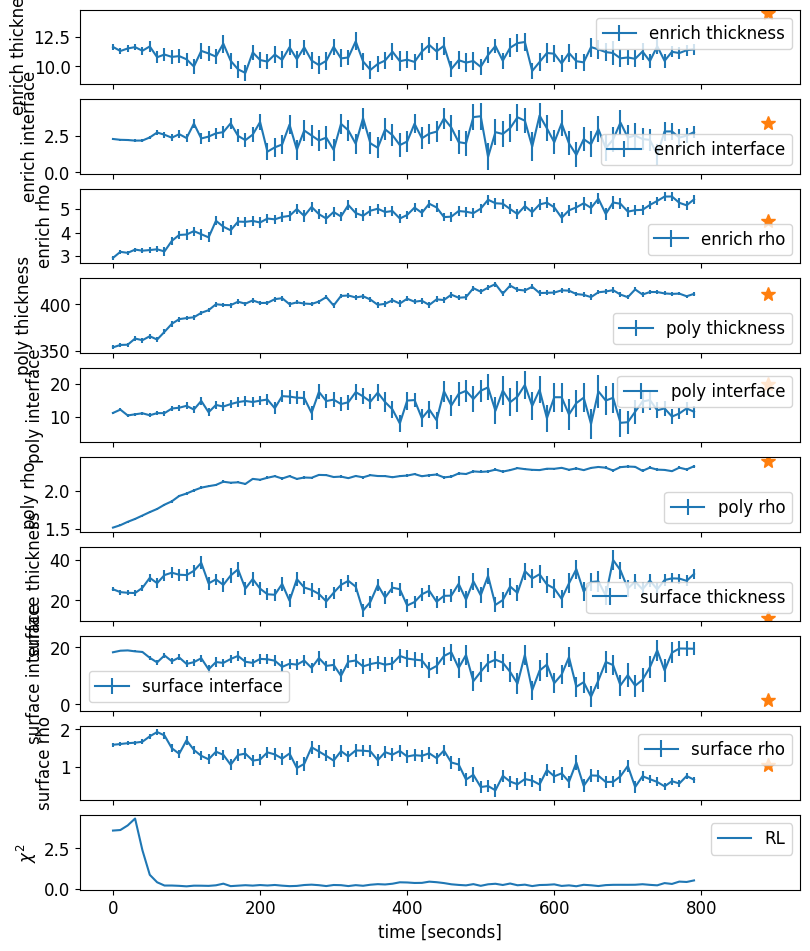

In [51]:
deltas = env.high_array - env.low_array
values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0

pars = values.T

# Bayesian fit trend
#with open(os.path.join(git_dir, 'data', '189245-bayes-forward.json')) as fd:
#    bayes_fits = json.load(fd)
bayes_fits = {}

t_delay = 100
if REVERSE:
    t_initial = timestamps[-1]+t_delay
    t_final = -t_delay
    _times = np.flip(timestamps)
else:
    t_final = timestamps[-1]+t_delay
    t_initial = -t_delay
    _times = timestamps

n_times = len(env.data)

n_pars = pars.shape[0]+1

fig, axs = plt.subplots(n_pars, 1, dpi=100, figsize=(9,10), sharex=True)
plt.subplots_adjust(left=0.15, right=.95, top=0.98, bottom=0.1)
        
print(env.par_labels)
for i in range(pars.shape[0]):
    ax = plt.subplot(n_pars, 1, i+1)
    
    plt.errorbar(_times, pars[i], yerr=errs[i], label=env.par_labels[i])

    label = env.par_labels[i].lower().replace(" ", "_")
    if label in bayes_fits:
        values = bayes_fits[label]
        d_values = bayes_fits[label+'_err']
        plt.errorbar(_times, values, yerr=d_values, label='Bayesian fit')
    
    plt.plot([t_initial,], [env.parameters[i]], linestyle='', marker='*', markersize=10)
    
    plt.ylabel(env.par_labels[i])
    plt.legend()

i +=1
ax = plt.subplot(n_pars, 1, i+1)
plt.plot(_times, chi2, label = 'RL')
#plt.plot(_times, bayes_fits['chi2'], label = 'Bayesian fit')
plt.legend()
plt.ylabel("$\chi^2$")
plt.xlabel("time [seconds]")

Number of times: 80


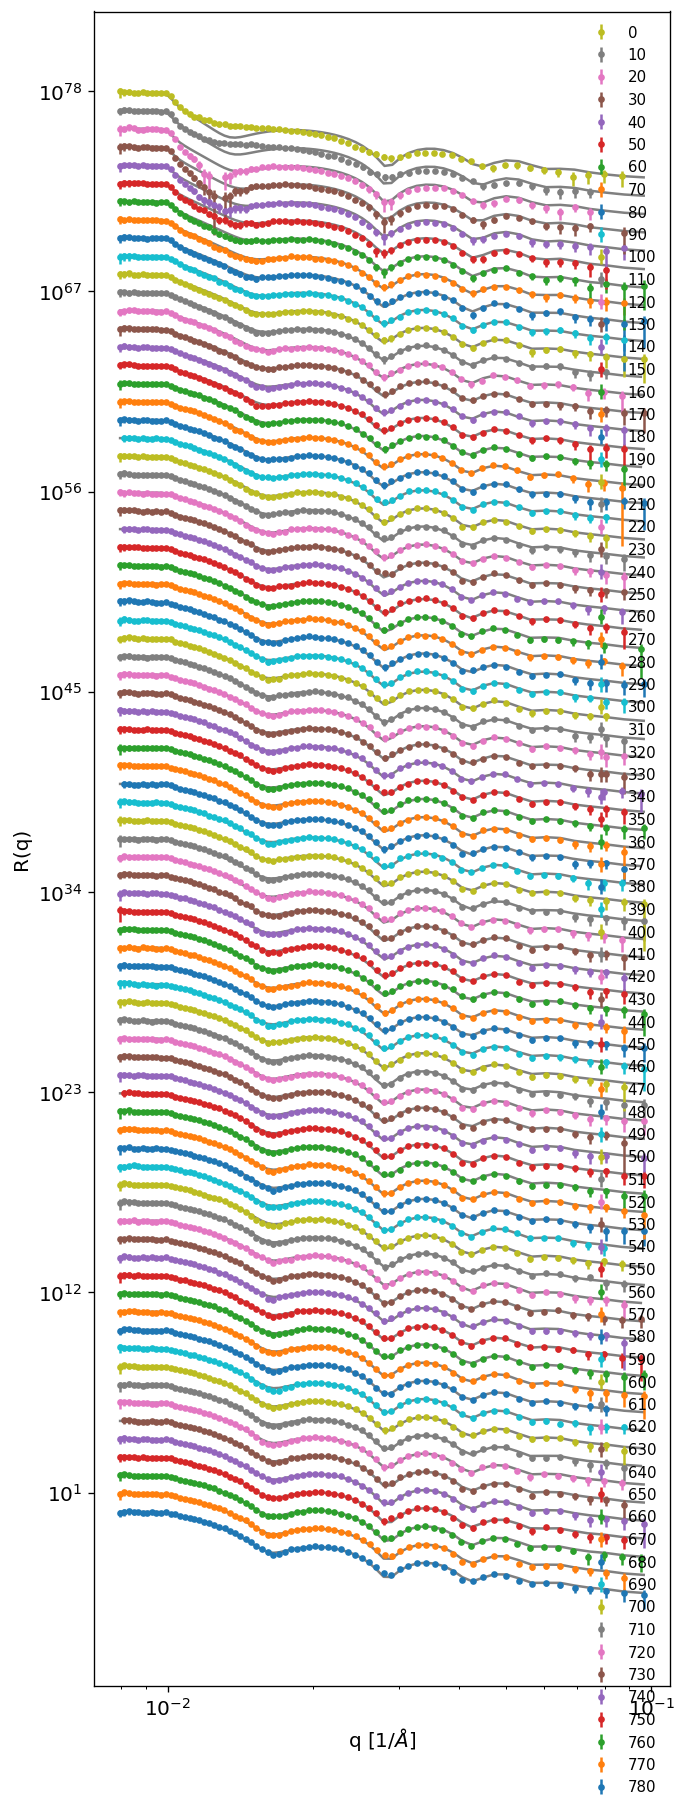

In [52]:
# Evaluate the agent
episode_reward = 0

n_times = len(env.data)
print("Number of times: %s" % n_times)

obs, info = env.reset()

fig, ax = plt.subplots(dpi=120, figsize=(6, 15))
plt.subplots_adjust(left=0.15, right=.95, top=0.98, bottom=0.05)

offset = 0
for i in range(1, n_times, 1):
    action, _ = model.predict(obs, deterministic=True)

    obs, reward, terminated, truncated, info = env.step(action)

    if True: #i%1000 == 0:
        env.plot(scale=10**offset, newfig=False, errors=True, label=_times[i])
        offset += 1

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], frameon=False, prop={'size': 9}, loc='upper right')
#plt.xlim([0.015, 0.12])
plt.show()